<p style='text-align: center'>
    <img src='images/cesi.png' width="20%">
    <div style='text-align: center'>Rima Benrejeb, Thomas Mattone, Bastien Reynaud, Badreddine Ferragh</div>
</p>



# Leyenda - Image classification

## **Table Of Contents**
> 1. [Objective](#1)
> 2. [Data](#2)
> 3. [Notebook imports](#3)
> 4. [Importing data](#4)
> 5. [Hyper-parameters](#5)
> 6. [Deep Neural Networks](#6)
> 7. [Convolutional Neural Networks](#7)
> 8. [Improving models](#8)
> 9. [Improving training](#9)
> 10. [Transfer Learning](#10)
> 11. [Results](#11)

## Objective <a class="anchor" id="1"></a> 

This notebook presents our implementation of an image classifier using Deep Learning.

It gathers our design process steps and idea on how to create the most accurate and efficient Neural Network for this task.

Please note that I you run this notebook code on your own, **you may encounter different accuracy results** than the ones we obtained. <br>
This is due on the way the `model.evaluate()` function works in TensorFlow.

## Data <a class="anchor" id="2"></a> 

The dataset is composed of 41.406 images splits into 5 differents classes: painting (10.000), photo (10.000), schematic (10.000), sketch (1406) and text (10.000). <br>
The images are either in .jpeg or .png format and come in variety of dimensions.

The make this notebook more easy to read, the original dataset has been pre-splits into a training (80%), validation (10%) and testing (10%) set, and then uploaded into a [Kaggle dataset](https://www.kaggle.com/datasets/eccsx20/image-type-classification). <br>
We also remove all non-processable images, due to invalid format or wrong color profile.

## Notebook imports <a class="anchor" id="3"></a> 

In [1]:
%load_ext watermark

import warnings
warnings.filterwarnings("ignore")

# File manipulation
import os
import pathlib
import shutil
import wget
import zipfile

# Data manipulation
import numpy as np

# Machine Learning
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Input, Flatten, MaxPool2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as tf_hub

tf.random.set_seed(1234)

# Image manipulation
import imghdr
from PIL import ImageFile

# Options for PIL
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import visualkeras

# Options for seaborn
sns.set_style('darkgrid')
%matplotlib inline

# Utils
import leyenda_utils as lu

%watermark -p watermark,wget,numpy,sklearn,tensorflow,tensorflow_hub,PIL,matplotlib,seaborn,visualkeras

watermark     : 2.3.1
wget          : 3.2
numpy         : 1.23.3
sklearn       : 1.1.1
tensorflow    : 2.9.1
tensorflow_hub: 0.8.0
PIL           : 9.2.0
matplotlib    : 3.5.2
seaborn       : 0.12.0
visualkeras   : 0.0.2



## Importing data <a class="anchor" id="4"></a>

We import the data from the [Kaggle dataset](https://www.kaggle.com/datasets/eccsx20/image-type-classification).

Please note that if you want to download the data using the following code, you will need to get your own download link. <br>
To do so, go on the dataset page and click on the 'download' at the top-right corner. Then quickly stop the dowload in your browser and right-click to retrieve the download link.

In [2]:
DATA_URL = None # YOUR DOWLOAD LINK HERE
DATA_PATH = 'data/image_type'

if not os.path.isdir(DATA_PATH):
    wget.download(DATA_URL)

    with zipfile.ZipFile('archive.zip') as zf:
        zf.extractall('data')

    os.remove('archive.zip')

Even if the dataset is already clean, we run a quick verification of all the images.

In [3]:
data_dir = pathlib.Path(os.path.join(DATA_PATH))
invalid_images = []

for file in list(data_dir.glob('*/*.*')):
    if imghdr.what(file) not in ['jpeg', 'png']:
        invalid_images.append(file)
        
print(f'{len(invalid_images)} invalids images')

0 invalids images


In the case we encounter no-usable images, we move them into a different directory.

In [4]:
if len(invalid_images) > 0:
    if not os.path.isdir('data/invalid'):
        os.mkdir('data/invalid')

    for image in invalid_images:
        shutil.move(image, 'data/invalid')

Then, we load the images into their respective training, valdation and testing set.

In the same time, we normalize all the image into the `IMG_H` by  `IMG_W` size, and map all pixel values between 0 and 1. <br>
The image labels are also converted into integers to make model training easier.

In [5]:
BATCH_SIZE = 32
IMG_H, IMG_W = 224, 224

data_gen = ImageDataGenerator(rescale=1/255)

train_data = data_gen.flow_from_directory(os.path.join(DATA_PATH, 'train'), 
                                          target_size=(IMG_H, IMG_W), 
                                          batch_size=BATCH_SIZE,
                                          class_mode='binary',
                                          seed=42)

val_data = data_gen.flow_from_directory(os.path.join(DATA_PATH, 'val'), 
                                        target_size=(IMG_H, IMG_W), 
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        seed=42)

test_data = data_gen.flow_from_directory(os.path.join(DATA_PATH, 'test'), 
                                         target_size=(IMG_H, IMG_W), 
                                         batch_size=BATCH_SIZE,
                                         class_mode='binary',
                                         seed=42)

Found 32538 images belonging to 5 classes.
Found 4065 images belonging to 5 classes.
Found 4072 images belonging to 5 classes.


In [6]:
print(train_data.class_indices)
print(val_data.class_indices)
print(test_data.class_indices)

CLASS_NAMES = list(train_data.class_indices.keys())
print(CLASS_NAMES)

{'painting': 0, 'photo': 1, 'schematic': 2, 'sketch': 3, 'text': 4}
{'painting': 0, 'photo': 1, 'schematic': 2, 'sketch': 3, 'text': 4}
{'painting': 0, 'photo': 1, 'schematic': 2, 'sketch': 3, 'text': 4}
['painting', 'photo', 'schematic', 'sketch', 'text']


## Visualizing the images <a class="anchor" id="3"></a> 

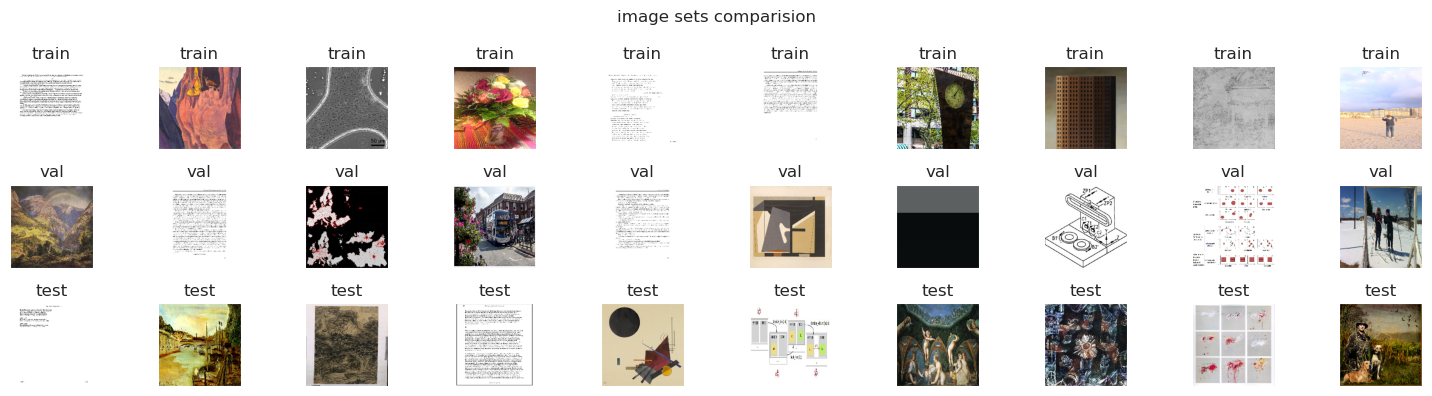

In [7]:
lu.compare_image_sets([train_data.next()[0], val_data.next()[0], test_data.next()[0]], 10,
                      labels=['train', 'val', 'test'],
                      size=(15, 4))
                      
train_data.reset()
val_data.reset()
test_data.reset()

## Hyper-parameters <a class="anchor" id="5"></a> 

In order to be able to compare the model troughout the notebook, we chose to training them using the same configuration.

In [8]:
NUM_EPOCH = 15
LOSS = SparseCategoricalCrossentropy()
OPTIMIZER = Adam(1e-3)
METRICS = [SparseCategoricalAccuracy()]

2022-10-21 09:25:36.138557: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-21 09:25:36.139659: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Deep Neural Network <a class="anchor" id="6"></a> 

### Baseline model

We began with a dummy `dnn_1`, to be able to visualize how behave a poorly designed network.

It is only composed of a `Dense` ouput layer.

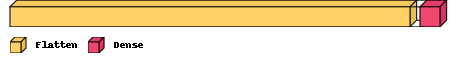

In [9]:
dnn_1 = Sequential([
    Flatten(input_shape=(IMG_H, IMG_W, 3)),
    Dense(units=len(CLASS_NAMES), activation='softmax')
], name='class_dnn_1')

dnn_1.compile(loss=LOSS,
              optimizer=OPTIMIZER,
              metrics=METRICS)

visualkeras.layered_view(dnn_1, legend=True)

In [10]:
if lu.is_model_already_trained(dnn_1):
    lu.load_model_training(dnn_1)
else:
    dnn_1.fit(train_data,
              epochs= NUM_EPOCH,
              validation_data = val_data)
            
    lu.save_model_training(dnn_1)

Without any surprise, the `loss` had trouble to deacreasing and the `accuracy` increase really slowly.

It is even worse for the `val_loss` and `val_accuracy` which are complety choatic.

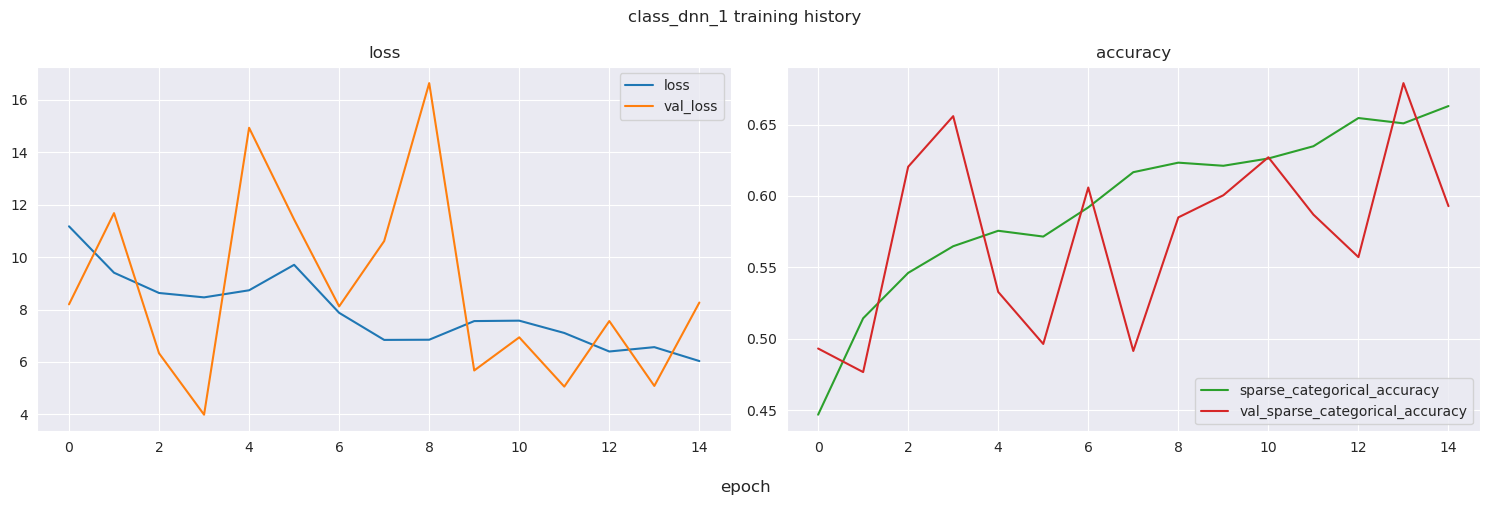

In [11]:
lu.plot_model_history(dnn_1)

`dnn_1` barely reach the 60% of accuracy.

In [12]:
dnn_1.evaluate(test_data)

128/128 [==============================] - 47s 366ms/step - loss: 8.6337 - sparse_categorical_accuracy: 0.5869


[8.633705139160156, 0.5869351625442505]

### Adding hidden layers

To start building a real network, we added multiple hidden layers.

`dnn_2` is made of 4 `Dense` hidden layers of respectively 1024, 512, 256, and 128 units, actived with the ReLU function.

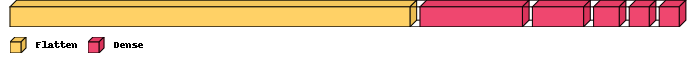

In [13]:
dnn_2 = Sequential([
    Flatten(input_shape=(IMG_H, IMG_W, 3)),
    Dense(units=1024, activation='relu'),
    Dense(units=512, activation='relu'),
    Dense(units=256, activation='relu'),
    Dense(units=128, activation='relu'),
    Dense(units=len(CLASS_NAMES), activation='softmax')
], name='class_dnn_2')

dnn_2.compile(loss=LOSS,
              optimizer=OPTIMIZER,
              metrics=METRICS)

visualkeras.layered_view(dnn_2, legend=True)

In [14]:
if lu.is_model_already_trained(dnn_2):
    lu.load_model_training(dnn_2)
else:
    dnn_2.fit(train_data,
              epochs= NUM_EPOCH,
              steps_per_epoch = len(train_data),
              validation_data = val_data,
              validation_steps = len(val_data))
            
    lu.save_model_training(dnn_2)

It's already doing much better.

The `loss` drops down quickly, and the `accuracy` is increasing. <br>
However, the `val_loss` and `val_accuracy` do not change a lot over time.

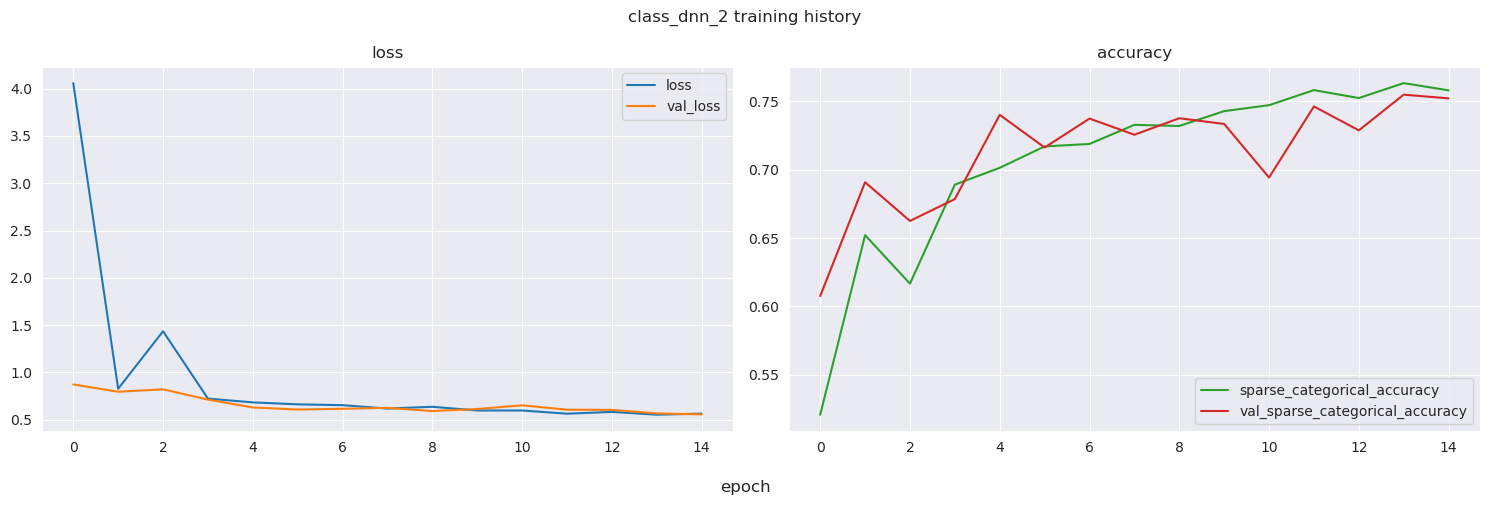

In [15]:
lu.plot_model_history(dnn_2)

Compare to `dnn_1`, `dnn_2` is more accurate but not enough to provide an efficient solution.

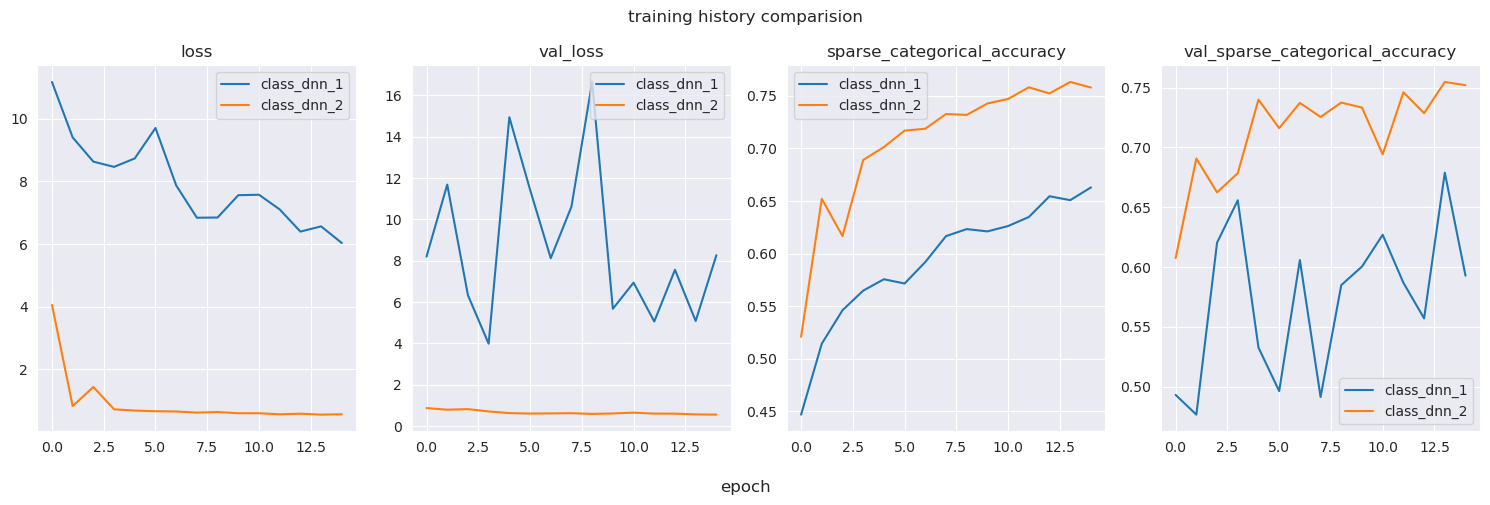

In [16]:
lu.load_model_training(dnn_1)

lu.plot_models_history([dnn_1, dnn_2])

`dnn_2` only offers an accuracy of 75%.

In [17]:
dnn_2.evaluate(test_data)

128/128 [==============================] - 50s 388ms/step - loss: 0.5588 - sparse_categorical_accuracy: 0.6729


[0.5588245391845703, 0.6728880405426025]

## Convolutional Neural Network <a class="anchor" id="7"></a> 

The reason of the bad performance of `dnn_1` and `dnn_2` for image classification is that Deep Neural Networks are not designed for that kind of task.

Convolutional Neural Networks were invented to provide a more meaningful way to analyse images in order to classifier them. <br>
Instead of processing all the pixels of an image at once, it goes through pixels groups using a kernel in order to detect image specicities like contours, edges or color changes.

<img src='images/convolution.gif'>

### Baseline model

Let's create a first simple one to see how more efficient it is regarding `dnn_2`.

`cnn_1` is composed of 2 `Conv2D` layers with 23 filter and a kernel size of 2, actived using the ReLU function. <br>
To classify, a simple `Dense` output layer is used.

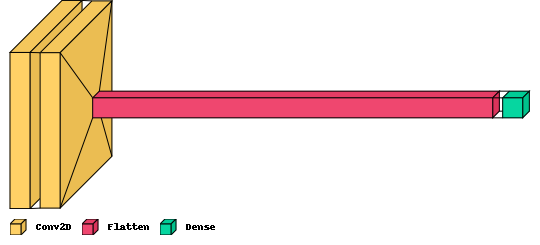

In [18]:
cnn_1 = Sequential([
    Input(shape=(IMG_H, IMG_W, 3)), 
    Conv2D(filters=32, kernel_size=2, activation='relu'),
    Conv2D(filters=32, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(len(CLASS_NAMES), activation='softmax')
], name='class_cnn_1')

cnn_1.compile(loss=LOSS,
              optimizer=OPTIMIZER,
              metrics=METRICS)

visualkeras.layered_view(cnn_1, legend=True, scale_xy=0.7)

In [19]:
if lu.is_model_already_trained(cnn_1):
    lu.load_model_training(cnn_1)
else:
    cnn_1.fit(train_data,
              epochs= NUM_EPOCH,
              steps_per_epoch = len(train_data),
              validation_data = val_data,
              validation_steps = len(val_data))
            
    lu.save_model_training(cnn_1)

We are on the way as `cnn_1`'s `loss` is almost 0 and its `accuracy` tends toward 100%.

However, a bigger problme is now showing up: the overfitting.

From this point, our biggest challenge is going to make `val_loss` decrease while increasing `val_accuracy`.

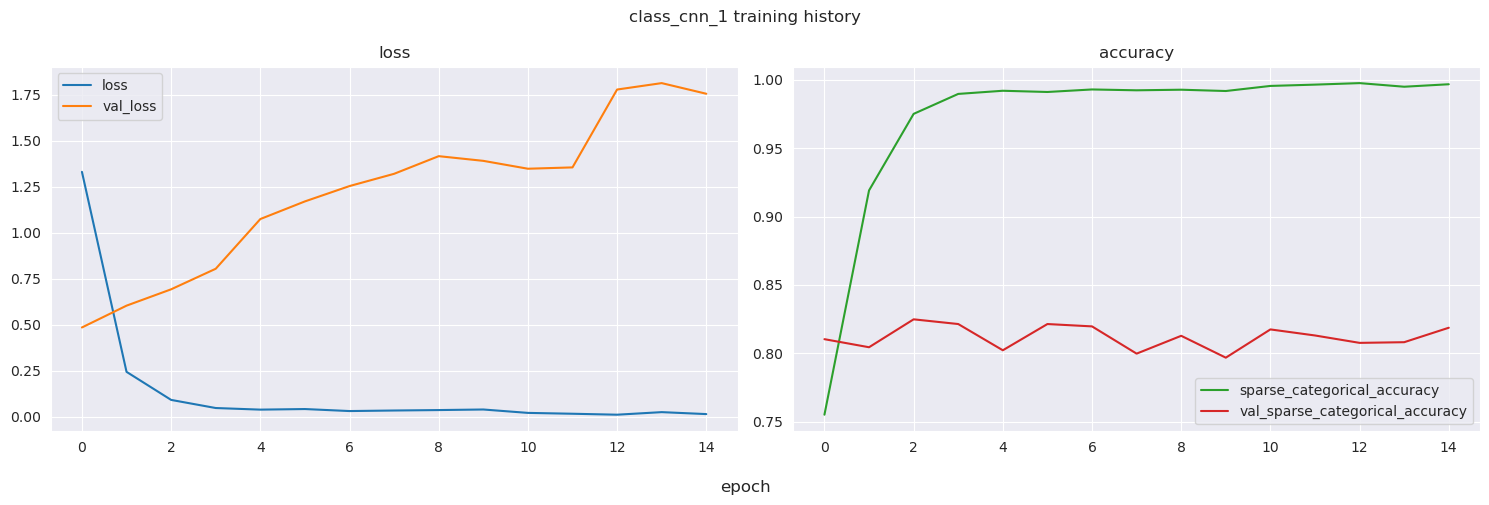

In [20]:
lu.plot_model_history(cnn_1)

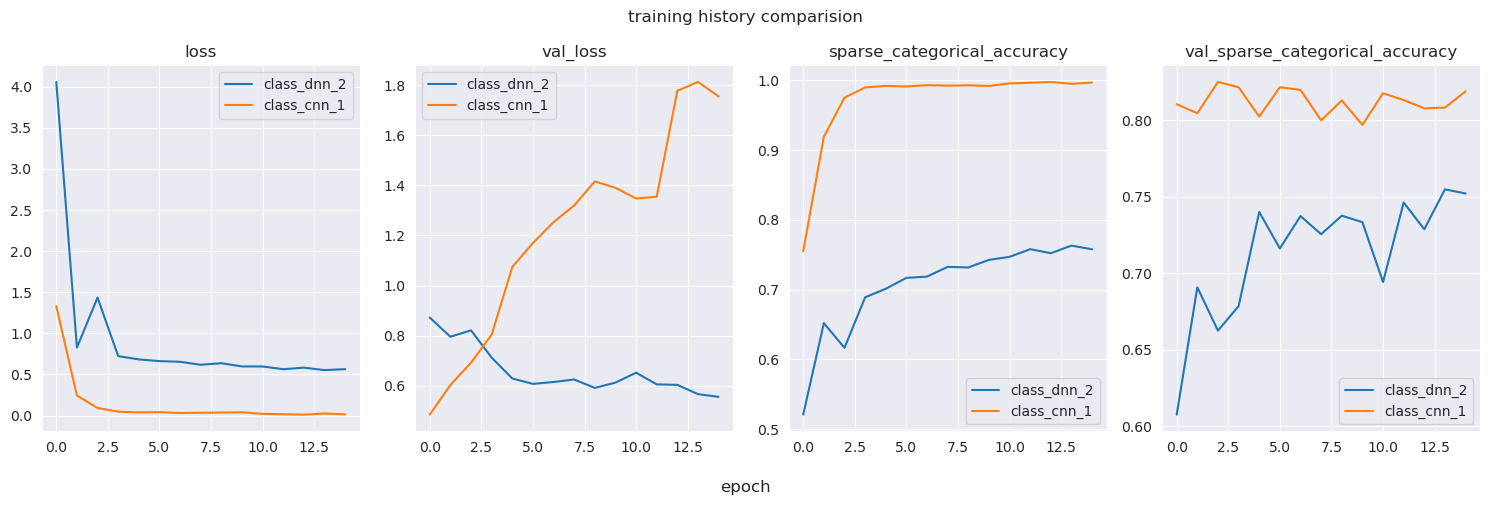

In [21]:
lu.load_model_training(dnn_2)

lu.plot_models_history([dnn_2, cnn_1])

This first iteration gives an accuracy around 80%. 

In [22]:
cnn_1.evaluate(test_data)

128/128 [==============================] - 52s 410ms/step - loss: 1.8451 - sparse_categorical_accuracy: 0.7216


[1.8451335430145264, 0.7215946316719055]

### Adding max-pooling layers

To improve our model, we can add `MaxPool2D` layers after each convolutional layer.

Max-pooling allowes to encode an image into smaller dimension by only keeping the maximum pixel value during the kernel iteration. <br>
It has many advantages such as only keeping relevant image information and reducing the duraiton of the training.

<img src='images/maxpooling.gif'>

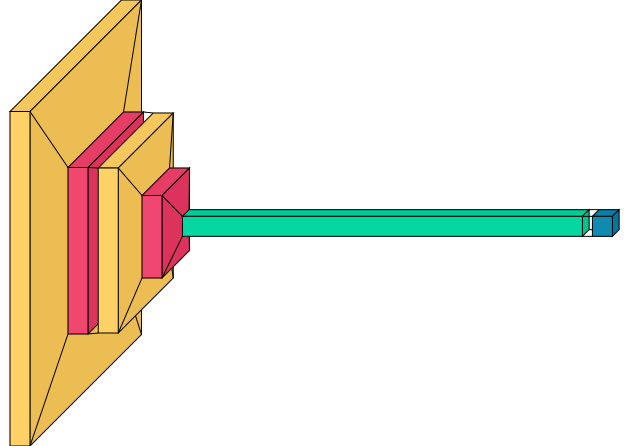

In [23]:
cnn_2 = Sequential([
    Input(shape = (224, 224, 3)),   
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), 
    MaxPool2D(pool_size = 2), # It will reduce the number of features by half
    Conv2D(filters = 32, kernel_size =2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Flatten(),
    Dense(len(CLASS_NAMES), activation = 'softmax')  
], name='class_cnn_2')

cnn_2.compile(loss = LOSS,
              optimizer = OPTIMIZER,
              metrics = METRICS)

visualkeras.layered_view(cnn_2, scale_xy=1.5)

In [24]:
if lu.is_model_already_trained(cnn_2):
    lu.load_model_training(cnn_2)
else:               
    cnn_2.fit(train_data,
            epochs= NUM_EPOCH,
            steps_per_epoch = len(train_data),
            validation_data = val_data,
            validation_steps = len(val_data))
            
    lu.save_model_training(cnn_2)

Despite the max-pooling, `cnn_2` is still overfitting but this time much slower.

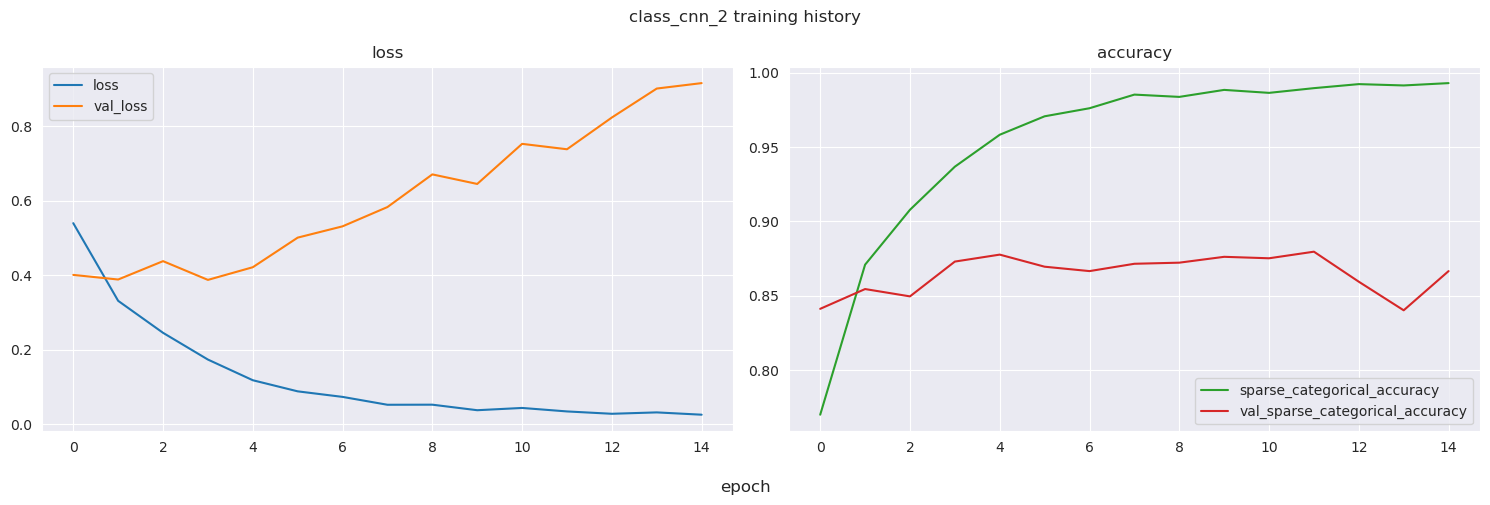

In [25]:
lu.plot_model_history(cnn_2)

It is still a good improvement compare to `cnn_1`, especially regarding the `val_accuracy`.

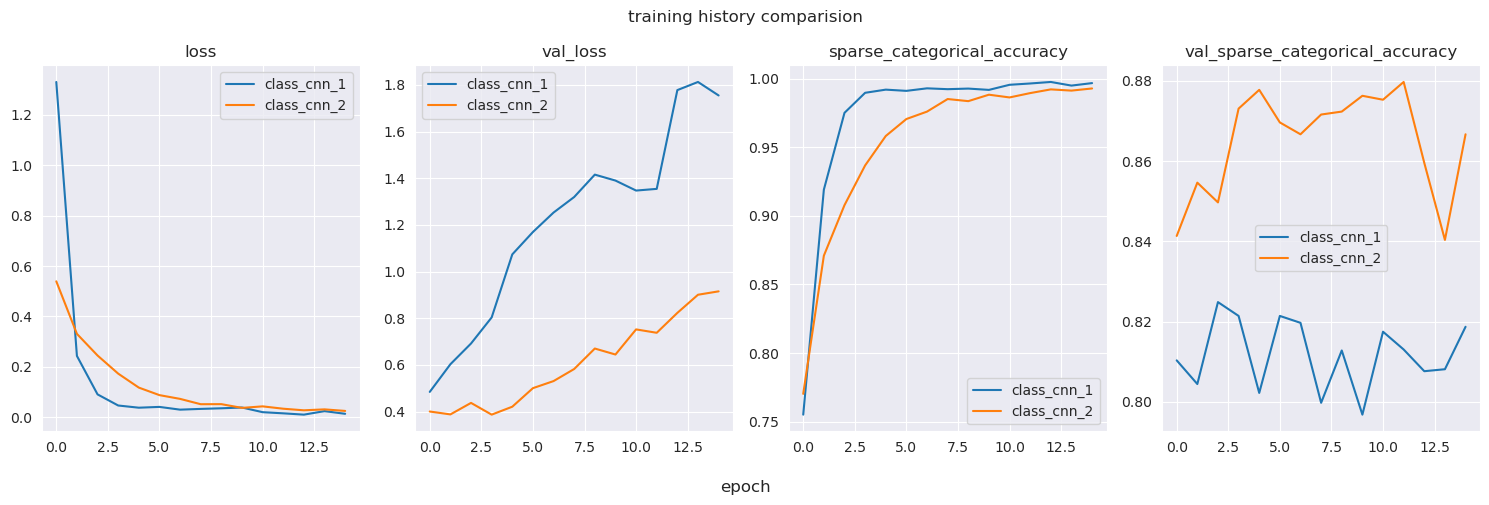

In [26]:
lu.load_model_training(cnn_1)

lu.plot_models_history([cnn_1, cnn_2])

`cnn_2` does sligthly better than it predecessor, reaching 84% of accuracy.

In [27]:
test_data.reset()

In [28]:
cnn_2.evaluate(test_data)

128/128 [==============================] - 52s 403ms/step - loss: 0.9991 - sparse_categorical_accuracy: 0.7561


[0.9991490244865417, 0.7560781240463257]

### Encoder

To improve improve our solution even, we can create an encoder.

To do so, we can add more `Conv2D` layers with an increasing number of filters adn a bigger kernel size.

To also improve the classification at the end of the convolution, we add a `Dense` layer of 512 units, precede by a `Droupout` of 50%.

Droupout is one of many techinique of weight regularization and helps reducing overfitting by ignore each epochs a certain percentage of neurons connection between two layers. 

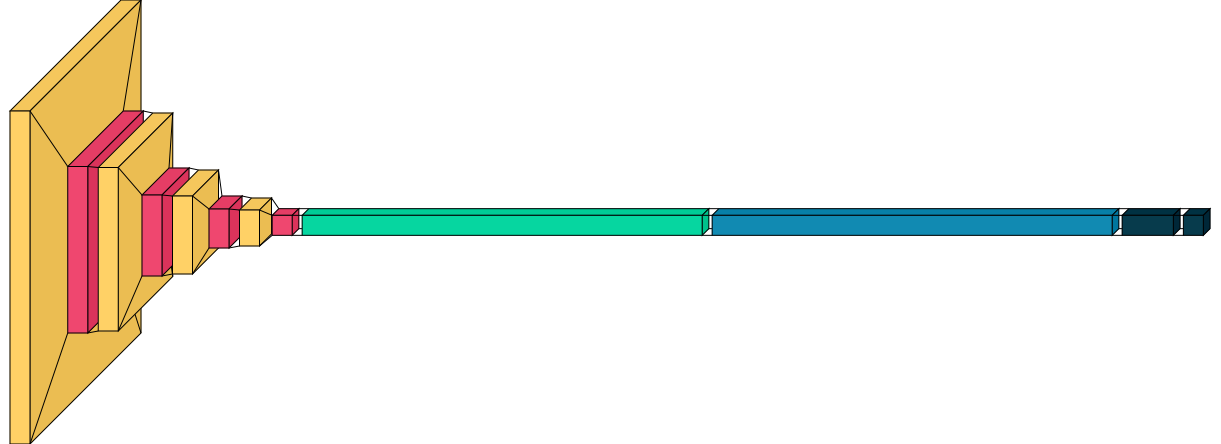

In [29]:
cnn_3 = Sequential([
    Input(shape=(IMG_H, IMG_W, 3)),
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(units=512, activation='relu'),
    Dense(units=len(CLASS_NAMES), activation='softmax')
], name='class_cnn_3')

cnn_3.compile(loss = LOSS,
              optimizer = OPTIMIZER,
              metrics = METRICS)

visualkeras.layered_view(cnn_3, scale_xy=1.5)

In [30]:
if lu.is_model_already_trained(cnn_3):
    lu.load_model_training(cnn_3)
else:               
    cnn_3.fit(train_data,
            epochs= NUM_EPOCH,
            steps_per_epoch = len(train_data),
            validation_data = val_data,
            validation_steps = len(val_data))
            
    lu.save_model_training(cnn_3)

With this type of architecture, `cnn_3` is finally starting to behave correctly.

Even if not by a lot, `val_loss` decreases and `val_accuracy` increases during the training.

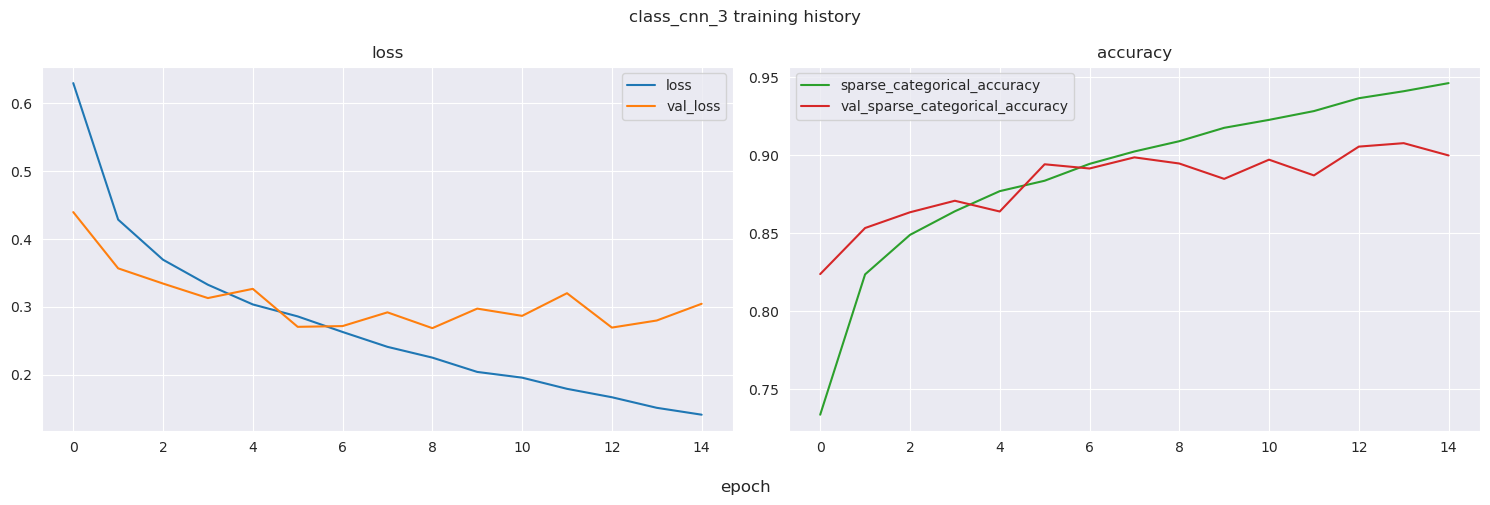

In [31]:
lu.plot_model_history(cnn_3)

In comparision with the previous model, `cnn_3` is much more promising.

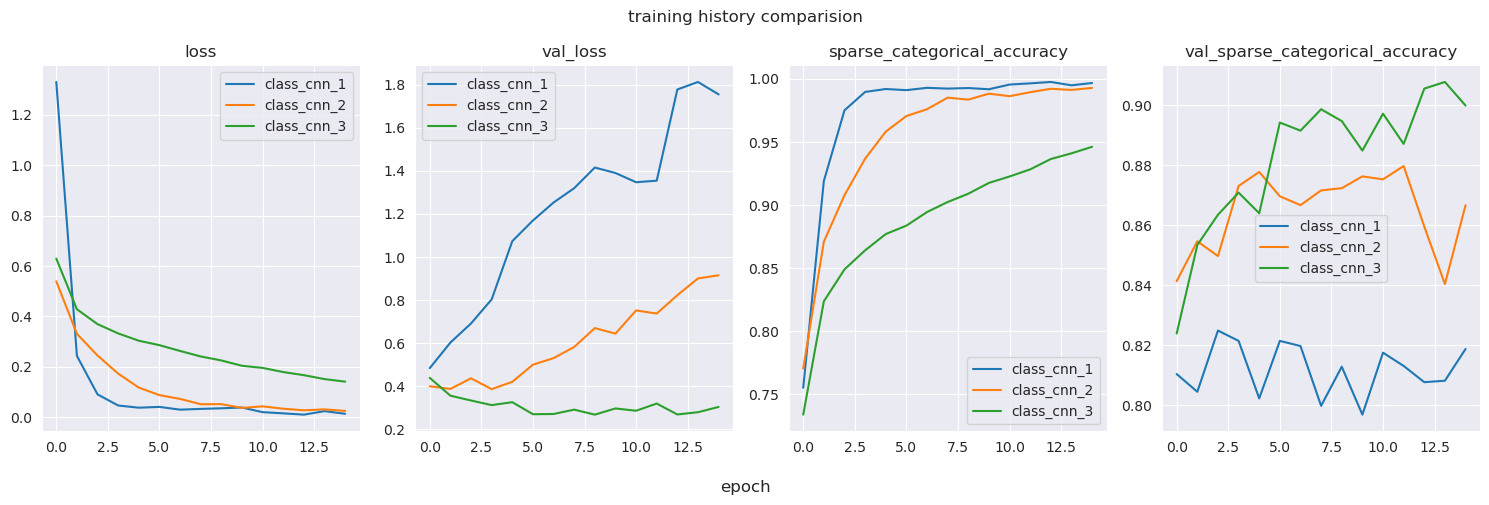

In [32]:
lu.load_model_training(cnn_1)
lu.load_model_training(cnn_2)

lu.plot_models_history([cnn_1, cnn_2, cnn_3])

After its training, `cnn_3` is just over 86% of accuracy.

In [33]:
cnn_3.evaluate(test_data)

128/128 [==============================] - 51s 396ms/step - loss: 0.2760 - sparse_categorical_accuracy: 0.7860


[0.2760028839111328, 0.786001980304718]

## Improving models <a class="anchor" id="8"></a> 

From now on, improving our models mostly relies on trial and error. <br>
Indeed, there is no today no existing method to fing the best model architecture for a given problem, and this topic is still an active field of research.

There are however some known techniques, call regularization, that can be used to reduce overfitting and improve the validation accuracy during training.

### Dropout

Already used in `cnn_3`, dropout allows each neurons connection between two layers has a certain percentage to be ignored at each epoch.
<img scr='images/dropout.gif'>

<img src='images/dropout.gif' width='30%'>

### L1 and L2 regularization

Allows to constrain the weights of a model to be smaller or to shrink some of them to 0.

### Early-stopping

Stops the training of a model when a metric such as the loss or the accuracy stop improving.

<img src='images/earlystopping.png'>

### Data augmentation

Creates new relevant data from the existing one.

In the case of image classes, we can create new images but apply transformation on images from the a dataset such as cropping, ratotions, symmetries, shifting or color modification. 

<img src='images/imageaugmentation.jpeg' width='60%'>

## Improving training <a class="anchor" id="9"></a> 

Random Search is a technique used for tuning hyperparameters in order to find those who suit best our model. <br>
In fact, it tests a certain number of combinations that are selected randomly. <br>
However, this technique require much ressources. 

The following code can be used in order to implement this technique:

```python
from  keras_tuner import RandomSearch
random_s= RandomSearch(cnn_3,
                       objectives= 'val_accuracy',
                       max_trials=15)
random_s.seach(train_data,
               epochs=5,
               validation_data= val_data,
               callbacks=[tf.keras.callbacks.EarlyStopping(patiente=1)])
```

## Transfer Learning <a class="anchor" id="10"></a>  

The idea behind Transfer Learning is to take an already existing model that has been trained on a similar task than ours, and then re-train it to fit our needs.

This methods is far more efficient compare to the trial-and-error approch because a lot of models has already been designed, trained and documented way better than what we could think of.

### VGG16

VGG16 is a Convolutional Neural Network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for the Large-Scale Image Recognition”.

The model achieves 92.7% test accuracy in ImageNet, which is the dataset of over 14 million images belonging to the 1000 classes.

Since our goal is similar, it would be interesting to try using Transfer Learning with this model.

In [34]:
base_model_vgg = tf.keras.applications.VGG16(input_shape = (IMG_H, IMG_W, 3),
                                             include_top = False,
                                             weights = 'imagenet')
                                             
for layer in base_model_vgg.layers:
    layer.trainable = False

Since we only want to keep the weigths of the VGG16 model, we desactivated the training of the convolutional layers.

Then to classify our images, we add the same `Dense` and `Dropout` layer configuration as our `cnn_3`.

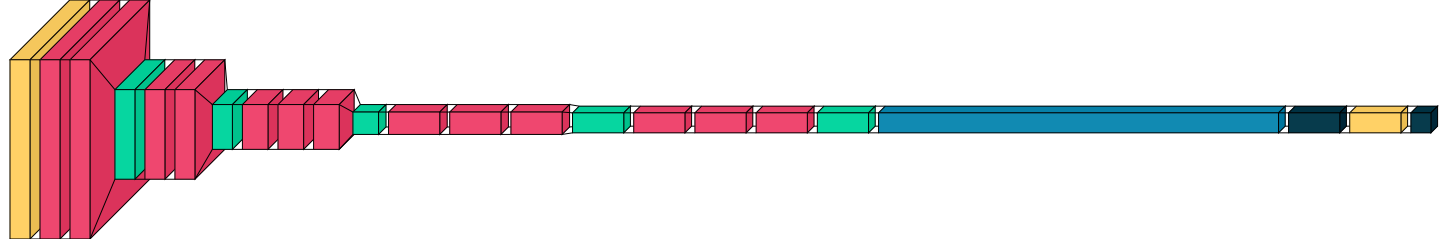

In [35]:
x = tf.keras.layers.Flatten()(base_model_vgg.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(x)

vgg_16 = tf.keras.models.Model(base_model_vgg.input, x) #merge the original VGG-16 layers, with our custom layers.
vgg_16._name = 'class_vgg16'

vgg_16.compile(loss = LOSS,
               optimizer = OPTIMIZER,
               metrics = METRICS)
               
visualkeras.layered_view(vgg_16, scale_xy=0.8)

In [36]:
if lu.is_model_already_trained(vgg_16):
    lu.load_model_training(vgg_16)
else:               
    vgg_16.fit(train_data,
            epochs= 5,
            steps_per_epoch = len(train_data),
            validation_data = val_data,
            validation_steps = len(val_data))
            
    lu.save_model_training(vgg_16)

Even if we reduce the number of epoch to 5 due to a lack of computational power, the re-trained VGG16 complety outperform our `cnn_3`.

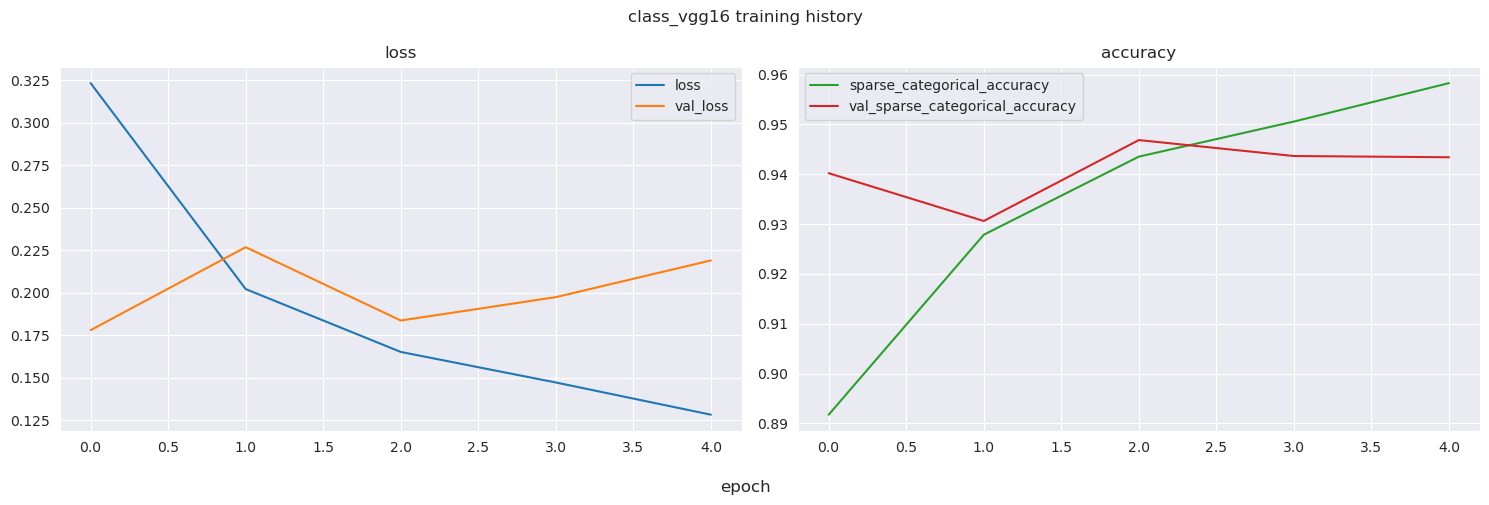

In [37]:
lu.plot_model_history(vgg_16)

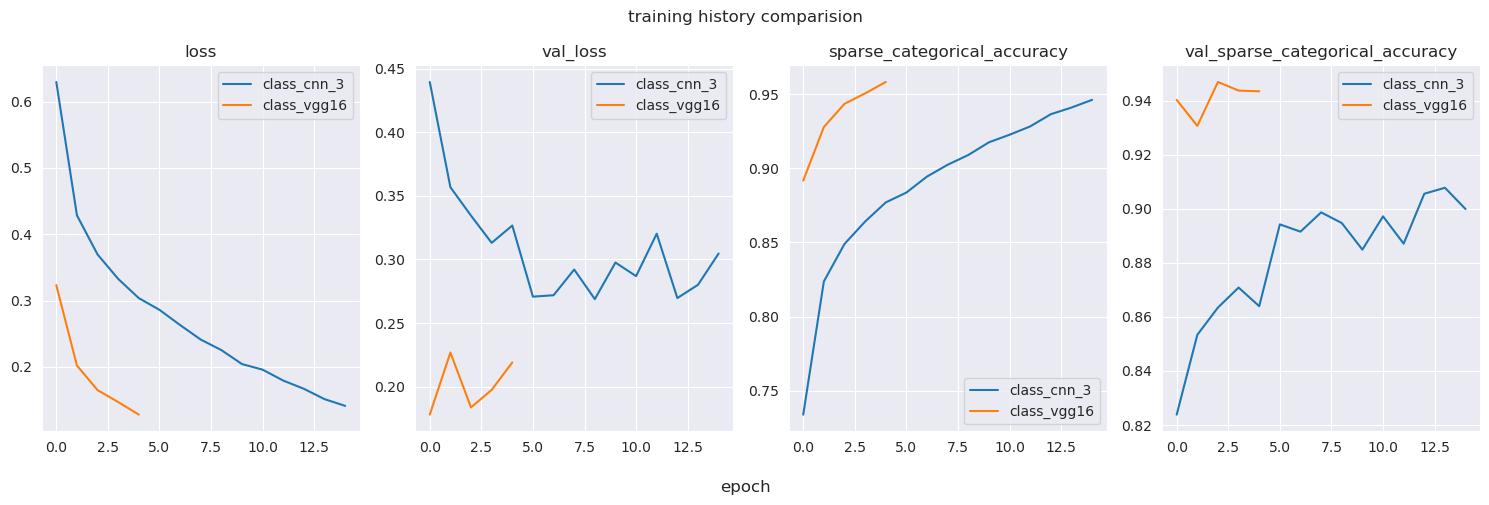

In [38]:
lu.load_model_training(cnn_3)

lu.plot_models_history([cnn_3, vgg_16])

`vgg_16` gives us an astonishing 94% of accuracy.

In [39]:
vgg_16.evaluate(test_data)

128/128 [==============================] - 343s 3s/step - loss: 0.2079 - sparse_categorical_accuracy: 0.8121


[0.20792227983474731, 0.8120906949043274]

### EfficientNetB7

EffecientNetB7 is a Convolutional Neural Network develop by Google AI, which reachs state-of-the-art accuracy on biggest image classification datasets.

In [40]:
feature_extractor_layer = tf_hub.KerasLayer('https://tfhub.dev/google/efficientnet/b7/feature-vector/1',
                                            trainable=False,
                                            input_shape=(224, 224, 3))

ef_net_b7 = Sequential([
    feature_extractor_layer,
    Dense(len(CLASS_NAMES), activation='softmax')
], name='class_efnetb7')

ef_net_b7.compile(loss = LOSS,
                  optimizer = OPTIMIZER,
                  metrics = METRICS)

<img src='images/efficientnetb7.png' width='60%'>

In [41]:
if lu.is_model_already_trained(ef_net_b7):
    lu.load_model_training(ef_net_b7)
else:               
    ef_net_b7.fit(train_data,
                  epochs= 5,
                  steps_per_epoch = len(train_data),
                  validation_data = val_data,
                  validation_steps = len(val_data))
            
    lu.save_model_training(ef_net_b7)

Also trained on 5 epoch, the EfficientNetB7 perform better then the VGG16.

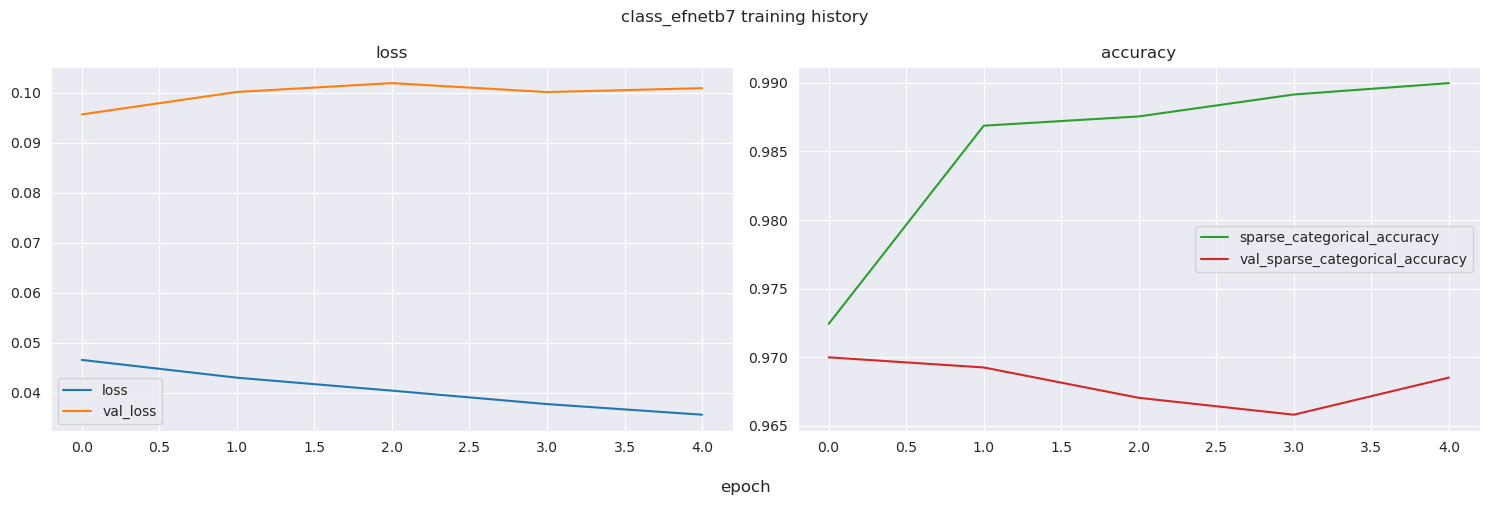

In [42]:
lu.plot_model_history(ef_net_b7)

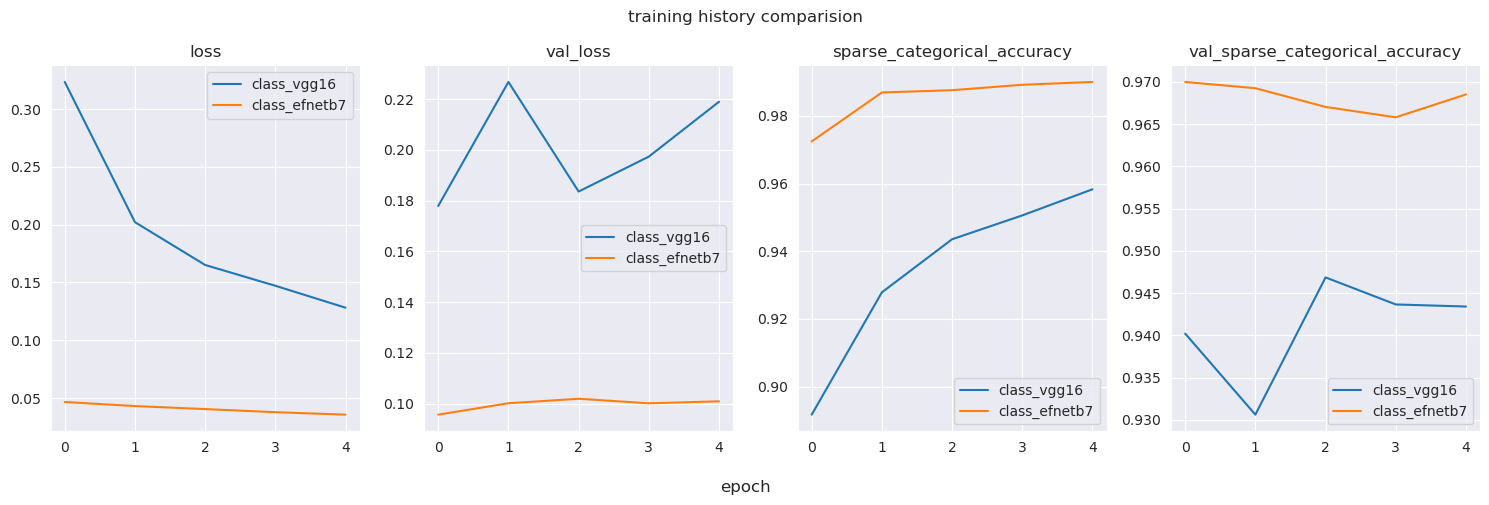

In [43]:
lu.load_model_training(vgg_16)

lu.plot_models_history([vgg_16, ef_net_b7])

`ef_net_b7` ends our image classification solution research with an 95.6% accuracy.

In [44]:
ef_net_b7.evaluate(test_data)

128/128 [==============================] - 427s 3s/step - loss: 0.0876 - sparse_categorical_accuracy: 0.8348


[0.0875735804438591, 0.8347600102424622]

## Results <a class="anchor" id="11"></a>  

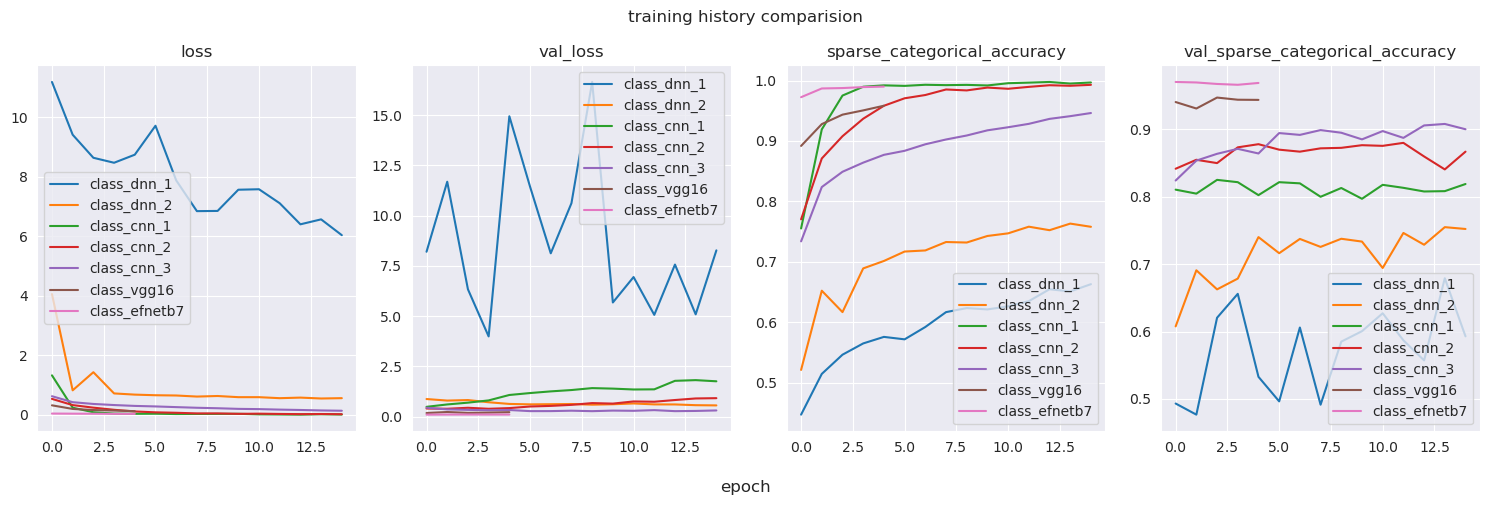

In [45]:
lu.load_model_training(dnn_1)
lu.load_model_training(dnn_2)
lu.load_model_training(cnn_1)
lu.load_model_training(cnn_2)
lu.load_model_training(cnn_3)
lu.load_model_training(vgg_16)
lu.load_model_training(ef_net_b7)

lu.plot_models_history([dnn_1, dnn_2, cnn_1, cnn_2, cnn_3, vgg_16, ef_net_b7])